# Building a Multimodal Agent

### Replicate AI: 
Replicate is a cloud-based platform that helps businesses run and host machine learning (ML) models.

### CrewAI: 
CrewAI is an open-source framework that uses artificial intelligence (AI) to orchestrate autonomous AI agents to work together as a team to complete tasks. 

### Groq: 
Groq is an artificial intelligence (AI) company that designs and manufactures hardware and software to speed up AI inference performance. 

## Install Required Dependencies

In [45]:
!pip install -qU langchain langchain_community tavily-python langchain-groq groq replicate
!pip install -qU crewai crewai[tools]

## Setup the Required API Keys

In [48]:
import os

os.environ['OPENAI_API_KEY'] = 'add your openai api key'
os.environ['REPLICATE_API_TOKEN'] = 'add your replicate api key'
os.environ['TAVILY_API_KEY'] = 'add your tavily api key'
os.environ['GROQ_API_KEY'] = 'add your groq api key'

### Create Web Search Tool Helper Function

In [49]:
from langchain_community.tools.tavily_search import TavilySearchResults
def web_search_tool(question: str) -> str:
    """This tool is useful when we want web search for current events."""
    # Function logic here
    # Step 1: Instantiate the Tavily client with your API key
    websearch = TavilySearchResults()
    # Step 2: Perform a search query
    response = websearch.invoke({"query":question})
    return response

### Create Helper Function to create Text to Speech Tool

In [50]:
## Tool for text to speech
import replicate
#
def text2speech(text:str) -> str:
    """This tool is useful when we want to convert text to speech."""
    # Function logic here
    output = replicate.run(
    "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
    input={
        "task_name": "T2ST (Text to Speech translation)",
        "input_text": text,
        "input_text_language": "English",
        "max_input_audio_length": 60,
        "target_language_text_only": "English",
        "target_language_with_speech": "English"
    }
    )
    return output["audio_output"]

### Helper function to create image from textual descriptions

In [52]:
#Create text to image
def text2image(text:str) -> str:
    """This tool is useful when we want to generate images from textual descriptions."""
    # Function logic here
    output = replicate.run(
    "adirik/flux-cinestill:216a43b9975de9768114644bbf8cd0cba54a923c6d0f65adceaccfc9383a938f",
    input={
        "steps": 28,
        "prompt": text,
        "lora_url": "",
        "control_type": "depth",
        "control_image": "https://replicate.delivery/pbxt/LUSNInCegT0XwStCCJjXOojSBhPjpk2Pzj5VNjksiP9cER8A/ComfyUI_02172_.png",
        "lora_strength": 1,
        "output_format": "webp",
        "guidance_scale": 2.5,
        "output_quality": 100,
        "negative_prompt": "low quality, ugly, distorted, artefacts",
        "control_strength": 0.45,
        "depth_preprocessor": "DepthAnything",
        "soft_edge_preprocessor": "HED",
        "image_to_image_strength": 0,
        "return_preprocessed_image": False
        }
    )
    print(output)
    return output[0]

### Helper function to process information from the Image provided

In [53]:
## text to image
def image2text(image_url:str,prompt:str) -> str:
  """This tool is useful when we want to generate textual descriptions from images."""
  # Function
  output = replicate.run(
    "adirik/flux-cinestill:216a43b9975de9768114644bbf8cd0cba54a923c6d0f65adceaccfc9383a938f",
    input={
        "image": image_url,
        "top_p": 1,
        "prompt": prompt,
        "max_tokens": 1024,
        "temperature": 0.2
    }
  )
  return "".join(output)

### Setup Router Tool

In [54]:
from crewai_tools import tool
## Router Tool
@tool("router tool")
def router_tool(question:str) -> str:
  """Router Function"""
  prompt = f"""Based on the Question provide below determine the following:
1. Is the question directed at generating image ?
2. Is the question directed at describing the image ?
3. Is the question directed at converting text to speech?.
4. Is the question a generic one and needs to be answered searching the web?
Question: {question}

RESPONSE INSTRUCTIONS:
- Answer either 1 or 2 or 3 or 4.
- Answer should strictly be a string.
- Do not provide any preamble or explanations except for 1 or 2 or 3 or 4.

OUTPUT FORMAT:
1
"""
  response = llm.invoke(prompt).content
  if response == "1":
    return 'text2image'
  elif response == "3":
    return 'text2speech'
  elif response == "4":
    return 'web_search'
  else:
    return 'image2text'

### Setup Retriever Tool

In [55]:
@tool("retriver tool")
def retriver_tool(router_response:str,question:str,image_url:str) -> str:
  """Retriver Function"""
  if router_response == 'text2image':
    return text2image(question)
  elif router_response == 'text2speech':
    return text2speech(question)
  elif router_response == 'image2text':
    return image2text(image_url,question)
  else:
    return web_search_tool(question)

### Setup the LLM

In [56]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="llama-3.1-70b-versatile",
    temperature=0.1,
    max_tokens=1000,
)

### Setup the Router Agent

In [57]:
from crewai import Agent
Router_Agent = Agent(
  role='Router',
  goal='Route user question to a text to image or text to speech or web search',
  backstory=(
    "You are an expert at routing a user question to a text to image or text to speech or web search."
    "Use the text to image to generate images from textual descriptions."
    "Use the text to speech to convert text to speech."
    "Use the image to text to generate text describing the image based on the textual description."
    "Use the web search to search for current events."
    "You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search."
  ),
  verbose=True,
  allow_delegation=False,
  llm=llm,
  tools=[router_tool],
)

### Setup the Retriever Agent

In [58]:
##Retriever Agent
Retriever_Agent = Agent(
role="Retriever",
goal="Use the information retrieved from the Router to answer the question and image url provided.",
backstory=(
    "You are an assistant for directing tasks to respective agents based on the response from the Router."
    "Use the information from the Router to perform the respective task."
    "Do not provide any other explanation"
),
verbose=True,
allow_delegation=False,
llm=llm,
tools=[retriver_tool],
)

### Setup the Router Task

In [59]:
from crewai import Task
router_task = Task(
    description=("Analyse the keywords in the question {question}"
    "If the question {question} instructs to describe a image then use the image url {image_url} to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question {question}."
    "Based on the keywords decide whether it is eligible for a text to image or text to speech or web search."
    "Return a single word 'text2image' if it is eligible for generating images from textual description."
    "Return a single word 'text2speech' if it is eligible for converting text to speech."
    "Return a single word 'image2text' if it is eligible for describing the image based on the question {question} and iamge url{image_url}."
    "Return a single word 'web_search' if it is eligible for web search."
    "Do not provide any other premable or explaination."
    ),
    expected_output=("Give a choice 'web_search' or 'text2image' or 'text2speech'  or 'image2text' based on the question {question} and image url {image_url}"
    "Do not provide any preamble or explanations except for 'text2image' or 'text2speech' or 'web_search' or 'image2text'."),
    agent=Router_Agent,
)

### Setup the Retriever Task

In [60]:
retriever_task = Task(
    description=("Based on the response from the 'router_task' generate response for the question {question} with the help of the respective tool."
    "Use the web_serach_tool to retrieve information from the web in case the router task output is 'web_search'."
    "Use the text2speech tool to convert the test to speech in english in case the router task output is 'text2speech'."
    "Use the text2image tool to convert the test to speech in english in case the router task output is 'text2image'."
    "Use the image2text tool to describe the image provide in the image url in case the router task output is 'image2text'."
    ),
    expected_output=("You should analyse the output of the 'router_task'"
    "If the response is 'web_search' then use the web_search_tool to retrieve information from the web."
    "If the response is 'text2image' then use the text2image tool to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question {question}."
    "If the response is 'text2speech' then use the text2speech tool to convert the text provided in the question {question} to speech"
    "If the response is 'image2text' then use the 'image2text' tool to describe the image based on the question {question} and {image_url}."
    ),
    agent=Retriever_Agent,
    context=[router_task],
)

### Setup the Crew

In [61]:
from crewai import Crew,Process
crew = Crew(
    agents=[Router_Agent,Retriever_Agent],
    tasks=[router_task,retriever_task],
    verbose=True,
)

2024-08-27 05:21:46,615 - 139302883231552 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


## Image Generation Task

### kickoff the crew

In [63]:
inputs ={"question":"Generate an image based upon this text: a close up portfolio photo of a beautiful Indian Model woman, perfect eyes, bright studio lights, bokeh, 50mm photo, neon pink visor","image_url":" "}
result = crew.kickoff(inputs=inputs)

 [2024-08-27 05:21:56][DEBUG]: == Working Agent: Router
 [2024-08-27 05:21:56][INFO]: == Starting Task: Analyse the keywords in the question Generate an image based upon this text: a close up portfolio photo of a beautiful Indian Model woman, perfect eyes, bright studio lights, bokeh, 50mm photo, neon pink visorIf the question Generate an image based upon this text: a close up portfolio photo of a beautiful Indian Model woman, perfect eyes, bright studio lights, bokeh, 50mm photo, neon pink visor instructs to describe a image then use the image url   to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question Generate an image based upon this text: a close up portfolio photo of a beautiful Indian Model woman, perfect eyes, bright studio lights, bokeh, 50mm photo, neon pink visor.Based on the keywords decide whether it is eligible for a text to image or text to speech or web search.Return a single word 'text2image

In [65]:
result.raw

'https://replicate.delivery/yhqm/SdnnwjVsqgo8MZLlr6n2sMDwyGWlJF7Qdjt4glYTrF5qUs1E/out-0.webp'

### Display the Image Generated

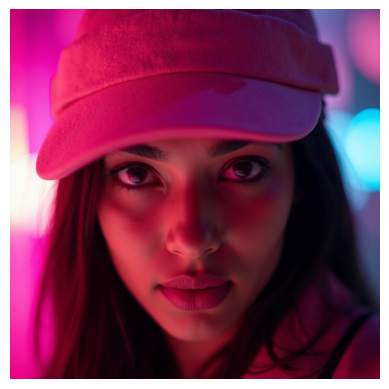

In [66]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# URL of the image
image_url = result.raw

# Fetch the image
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image using PIL
    img = Image.open(BytesIO(response.content))

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("Failed to retrieve image. Status code:", response.status_code)

### Kickoff the crew to describe the image based on the user instruction

In [67]:
inputs ={"question":"Provide a detailed description.","image_url":"https://images.unsplash.com/photo-1470770903676-69b98201ea1c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1740&q=80.jpg"}
result = crew.kickoff(inputs=inputs)

 [2024-08-27 05:24:38][DEBUG]: == Working Agent: Router
 [2024-08-27 05:24:38][INFO]: == Starting Task: Analyse the keywords in the question Provide a detailed description.If the question Provide a detailed description. instructs to describe a image then use the image url https://images.unsplash.com/photo-1470770903676-69b98201ea1c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1740&q=80.jpg to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question Provide a detailed description..Based on the keywords decide whether it is eligible for a text to image or text to speech or web search.Return a single word 'text2image' if it is eligible for generating images from textual description.Return a single word 'text2speech' if it is eligible for converting text to speech.Return a single word 'image2text' if it is eligible for describing the image based on the question Provide a det

In [70]:
result.raw

'The image provided is a photograph of a person sitting on a rock at the edge of a body of water, with a mountain range in the background. The person is looking out at the water, and their facial expression is contemplative. The image is in color and has a natural, serene atmosphere.'